# Spatio-Temporal Data - Appendix
This appendix is thought to introduce some of the topics presented in the lecture in more detail. It should provide you background information and can be usefull if want to go further into following topics:
1. Discretization/resampling of data
2. Moving average
3. H3 polygons generation from map boundary data

In [1]:
# Imports for the whole notebook:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json
import contextily as ctx
import mplleaflet
#%matplotlib notebook
from matplotlib import pyplot as plt
from IPython.display import display
from h3 import h3
from shapely.ops import cascaded_union
from shapely.geometry import mapping
from IPython.display import YouTubeVideo, Image
from shapely_geojson import dumps
from shapely import geometry
import warnings
warnings.filterwarnings('ignore')
# Fix for ssl certificate
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

---
## 1. Discretization/resampling of Data

**Upsampling**

The observations in our carshring dataset do not have a equidistant time intervall. Imagine that we need this data for our analyis in a secondly resolution. We would have to upsample the frequency to secondly. **But be careful** while upsampling your data. Basically it looks like you have more data at the end, but always remeber that any new datapoint is just a composite of your original dataset.

StartTime
2019-07-01 00:03:04    12
2019-07-01 00:03:05     0
2019-07-01 00:03:06     0
2019-07-01 00:03:07     0
2019-07-01 00:03:08     0
Freq: S, Name: pickups_secondly, dtype: int64

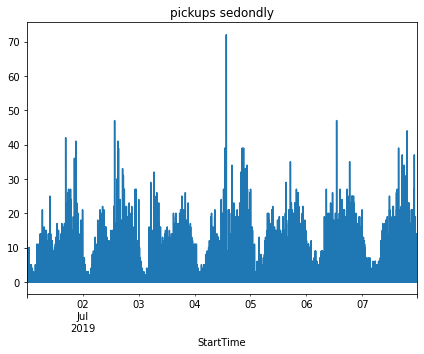

In [2]:
# Read carshating dataset
df_fleet = pd.read_csv('data/carsharing.csv', parse_dates=['StartTime', 'DestinationTime'])

# Load Pickups into GeoDataFrame
gdf_pickups = gpd.GeoDataFrame(crs='epsg:4326', geometry=gpd.points_from_xy(df_fleet.StartLongitude, df_fleet.StartLatitude))
gdf_pickups.index = df_fleet.StartTime

# Sample the timeseries with secondly frequency
pickups_secondly = gdf_pickups.geometry.resample('1S').count().rename('pickups_secondly')

# Look at the data
display(pickups_secondly.head())

# Plot the data
fig, (ax1) = plt.subplots(1, figsize=(7,5))
pickups_secondly.plot(ax = ax1, title="pickups sedondly")
plt.show()

---
## 2. Moving average

>Moving average smoothing is a naive and effective technique in time series analysis. It can be used for data preparation, feature engineering, and even directly for making predictions. 
Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes. Moving averages are a simple and common type of smoothing used in time series analysis and time series forecasting. Calculating a moving average involves creating a new series where the values are comprised of the average of raw observations in the original time series. A moving average requires that you specify a window size called the window width. This
defines the number of raw observations used to calculate the moving average value. The moving part in the moving average refers to the fact that the window defined by the window width is slid along the time series to calculate the average values in the new series. There are two main types of moving average that are used: Centered and Trailing Moving Average. *Brownlee, J. (2018). Inroduction to Time Series Forecasting with Python (Vol. v1.5).*

`Pandas` offers function called `rolling()`, wich gives us a rolling window over our dataset. Together with an aggregate function (in our case `mean()`) we get a moving average of our dataset. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

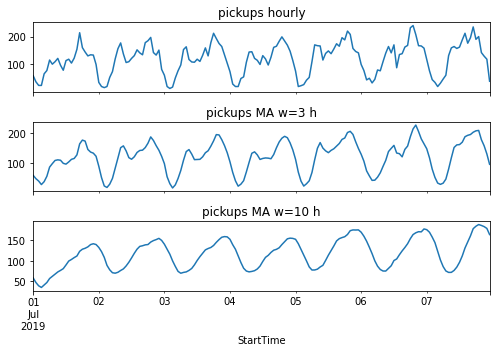

In [3]:
# Get figure with 3 subplots and shared axes
fig, ax = plt.subplots(3,1, figsize=(7,5), sharex=True)

# Plot actual time series
pickups_hourly = gdf_pickups.geometry.resample('1H').count()
pickups_hourly.plot(ax = ax[0], title='pickups hourly')

# Apply and plot a moving average with windowsize 3 h
pickups_hourly.rolling('3h').mean().plot(ax = ax[1], title='pickups MA w=3 h')

# Apply and plot a moving average with windowsize 3 h
pickups_hourly.rolling('10h').mean().plot(ax = ax[2], title='pickups MA w=10 h')

plt.tight_layout()
plt.show()

---
## 3. H3 Polygon Generation from Map Boundary Data
It is often the case that you start from available map data that describes the border of a specific area, e.g., the city area of Munich. The h3 toolbox can be used to slice this boundary area into several h3 cells of desired size for spatial discretization. 

This approach is described for Munich in the following.

### Load Boundary Data to Fill with Hexagons

In [4]:
# Load munich-boundary geoJSON in a geoDataFrame 
gdf_munich_boundary = gpd.read_file('data/munich-boundary.geojson')

# Plot the city-boundary using mplleaflet
fig, ax = plt.subplots(1)
fig.set_size_inches(10,7)
gdf_munich_boundary.to_crs(epsg=4326).plot(ax = ax, alpha= 0.3, edgecolor='black')
mplleaflet.display(fig=fig)

### H3 Hexagon Resolution
You can set different level of resolution for the h3 hexagons. Depending on your application you need to select an appropiate resolution. Note that a very high resolutions leeds to a fine grained map but it might be difficult to obtain usefull information from this grid as spatial relations are neglected.

In [5]:
# H3 max resolution
max_res = 15

# Prepare empty dataframe 
df_h3_meta = pd.DataFrame(columns=['edge_length_km','perimeter_km','area_sqkm'])

# Get dimensions for every resolution, using h3 API functions
for i in range(0, max_res + 1):
    edge_length_km = h3.edge_length(resolution=i, unit='km')
    perimeter_km = 6 * edge_length_km
    area_sqkm = h3.hex_area(resolution=i, unit='km^2')
    df_h3_meta = df_h3_meta.append({'edge_length_km':edge_length_km, 'perimeter_km': perimeter_km,
                                    'area_sqkm':area_sqkm}, ignore_index=True)
    
# Display results
display(df_h3_meta)

,edge_length_km,perimeter_km,area_sqkm
0,1107.712591,6646.275546,4.250547e+06
1,418.676005,2512.056033,6.072210e+05
2,158.244656,949.467935,8.674585e+04
3,59.810858,358.865148,1.239226e+04
4,22.606379,135.638276,1.770324e+03
5,8.544408,51.266450,2.529034e+02
6,3.229483,19.376897,3.612905e+01
7,1.220630,7.323779,5.161293e+00
8,0.461355,2.768128,7.373276e-01
9,0.174376,1.046254,1.053325e-01


### Fill Geometry with Hexagons
Let's create h3 hexagons for the city of Munich:

In [6]:
# Load the geoJSON in a JSON object
munich_geojson = json.load(open('data/munich-boundary.geojson'))

# H3 API only accepts the geometry node, so lets see how we get it
geometry_geojson = munich_geojson['features'][0]['geometry']

# For this example we use level 8 as an appropriate grid size
h3_resolution = 8

# Use polyfill to fill the given geometry with hexagons at a given resolution
h3_indexes = h3.polyfill(geo_json=geometry_geojson, res=h3_resolution, geo_json_conformant=True)

# Convert them into a DataFrame for convienience
df_munich_h3 = pd.DataFrame(h3_indexes, columns=['h3_index'])

# Lets see what we've got 
display(df_munich_h3.head())
print('Number of indexes: {}'.format(len(df_munich_h3)))

,h3_index
0,881f8d7321fffff
1,881f8d44d5fffff
2,881f8d4711fffff
3,881f8d4497fffff
4,881f8d4433fffff


Number of indexes: 437


We got a list of h3-indexes which fill into the given boundary. This is a good start, but how do we get the shapes of the hexagons? 

In [7]:
# Use h3_to_geo_boundary to get them.
df_munich_h3['geometry'] = df_munich_h3.h3_index.apply(h3.h3_to_geo_boundary)

# Let's see what we got:
df_munich_h3.head()

,h3_index,geometry
0,881f8d7321fffff,"[[48.191500538981636, 11.62122701973368], [48...."
1,881f8d44d5fffff,"[[48.18306027593503, 11.579279853267131], [48...."
2,881f8d4711fffff,"[[48.19565386851138, 11.438138454465506], [48...."
3,881f8d4497fffff,"[[48.16446019336686, 11.60945115141749], [48.1..."
4,881f8d4433fffff,"[[48.16276802953275, 11.51946515574001], [48.1..."


**Remark**: Unfortunately h3 returns a `[lat,lon]` list. To convert it to `shapely.Polygon` we need to rearrange the list to `[lon,lat]`

In [8]:
# Define a small function which can be applied to the DataFrame column
def reverse_lat_lon(hex_coords):
    geom_hex = []
    for lat_lon in hex_coords:
        geom_hex.append([lat_lon[1],lat_lon[0]])
    return geom_hex

# Reorder lat, lon applying the funtion
df_munich_h3['geometry'] = df_munich_h3.geometry.apply(reverse_lat_lon)

# Let's see what we got
df_munich_h3['geometry']

0      [[11.62122701973368, 48.191500538981636], [11....
1      [[11.579279853267131, 48.18306027593503], [11....
2      [[11.438138454465506, 48.19565386851138], [11....
3      [[11.60945115141749, 48.16446019336686], [11.6...
4      [[11.51946515574001, 48.16276802953275], [11.5...
                             ...                        
432    [[11.414104834124966, 48.19900118653234], [11....
433    [[11.510241807807132, 48.1855788752289], [11.5...
434    [[11.561383239493065, 48.171229193220896], [11...
435    [[11.481230221611535, 48.08919210936073], [11....
436    [[11.633485652690124, 48.16106742990071], [11....
Name: geometry, Length: 437, dtype: object

### Convert Nodes to shapely.Polygon
Convert the nodes to `shapely.Polygon` and store them in a `GeoDataFrame`.

In [9]:
# Convert into shapely Polygon
df_munich_h3['geometry'] = df_munich_h3.geometry.apply(geometry.Polygon)

# Make GeoDataFrame, Points are in WGS84 so we use EPSG:4326
gdf_munich_h3 = gpd.GeoDataFrame(geometry = df_munich_h3.geometry, crs = {'init':'epsg:4326'})

# Use h3 index as index for the GeoDataFrame
gdf_munich_h3.index = df_munich_h3.h3_index

# Let's see what we got
display(gdf_munich_h3.head())

# Make a plot using mplleaflet
fig, ax = plt.subplots(1, dpi=300)

gdf_munich_h3.to_crs(epsg=4326).plot(ax=ax, alpha=1, facecolor='none', edgecolor='black')
fig.set_size_inches(10,7)
mplleaflet.display(fig=fig)

# The gdf can be saved to a .geojson file by using the GeoDataFrame.to_file() function
#gdf_munich_h3.to_file("data/gdf_munich_h3.geojson", driver='GeoJSON')

,geometry
h3_index,
881f8d7321fffff,"POLYGON ((11.62123 48.19150, 11.61926 48.18699..."
881f8d44d5fffff,"POLYGON ((11.57928 48.18306, 11.57732 48.17855..."
881f8d4711fffff,"POLYGON ((11.43814 48.19565, 11.43619 48.19115..."
881f8d4497fffff,"POLYGON ((11.60945 48.16446, 11.60749 48.15995..."
881f8d4433fffff,"POLYGON ((11.51947 48.16277, 11.51751 48.15826..."
